In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [37]:
raster = np.load("/shares/wegner.ics.uzh/CHELSA/Switzerland/1981-2010_numpy/" + "03" + "_monthly_float16.npy").astype("float")
raster2 = np.load("/shares/wegner.ics.uzh/CHELSA/Switzerland/1981-2010_numpy/" + "04" + "_monthly_float16.npy").astype("float")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


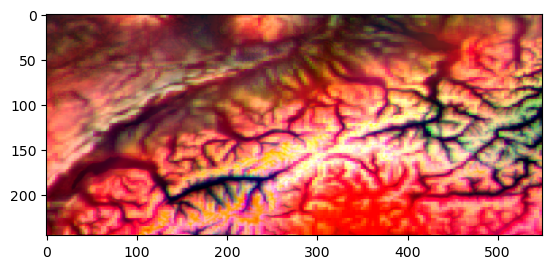

In [35]:
plt.imshow(raster2[:3].transpose(1,2,0).astype("float"))
plt.show()

In [84]:
grads = np.delete(np.array(np.gradient(np.stack([raster, raster2]))), 1, 0)
print(grads.shape)
grads = grads.reshape(-1, 245, 550)
gnorm = np.sqrt(grads**2)
sharpness = np.average(gnorm, axis=0)

(3, 2, 11, 245, 550)


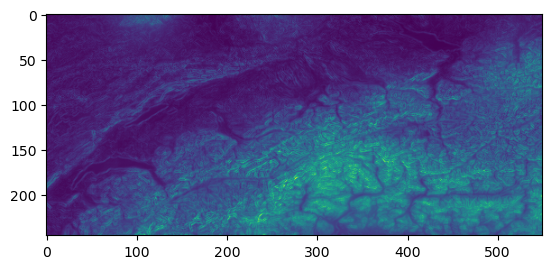

In [85]:
plt.imshow(sharpness.astype("float"))
plt.show()

In [64]:
y, x = np.where(sharpness>0.45)
sharpness[y, x]

array([0.45778695, 0.47038425])

In [82]:
a = np.array([[1,1,1],[2,2,2]])
grad = np.gradient(a)
print(a.shape, np.stack(grad).shape)
print(grad)

(2, 3) (2, 2, 3)
[array([[1., 1., 1.],
       [1., 1., 1.]]), array([[0., 0., 0.],
       [0., 0., 0.]])]


In [100]:
a = np.array([1,4,3, np.nan, np.nan, 4,6])
np.nanmean(np.gradient(a))
a[a>=4] = np.nan
a

array([ 1., nan,  3., nan, nan, nan, nan])

In [106]:
a = np.array([[1,1,1],[2,2,2]])
a.shape

(2, 3)

(array([1.1230e+03, 6.0730e+03, 1.3180e+04, 1.3585e+04, 1.0720e+04,
        7.7080e+03, 5.6760e+03, 4.5040e+03, 4.2990e+03, 4.8420e+03,
        5.2170e+03, 5.6360e+03, 5.3780e+03, 5.2830e+03, 5.0240e+03,
        4.6340e+03, 4.2770e+03, 3.9470e+03, 3.6260e+03, 3.3320e+03,
        2.9570e+03, 2.6010e+03, 2.1990e+03, 1.8610e+03, 1.7220e+03,
        1.2910e+03, 1.0820e+03, 8.1600e+02, 6.5900e+02, 4.6700e+02,
        3.1800e+02, 2.3300e+02, 1.5000e+02, 1.1600e+02, 7.1000e+01,
        4.6000e+01, 4.3000e+01, 2.0000e+01, 1.1000e+01, 9.0000e+00,
        7.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.02361072, 0.02993876, 0.03626679, 0.04259482, 0.04892285,
        0.05525089, 0.06157892, 0.06790695, 0.07423499, 0.08056302,
        0.08689105, 0.09321909, 0.09954712, 0.10587515, 0.11220319,
        0.11853122, 0.12485925, 0.13118728, 0.13751532, 0.14384335,
        0.15017138, 0.15649942, 0.16282745, 0.

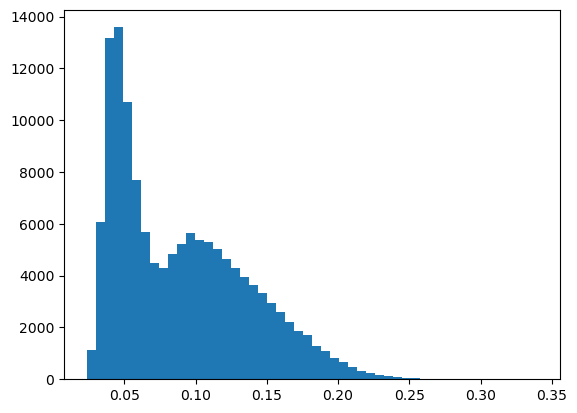

In [86]:
plt.hist(sharpness.flatten(), bins=50)

In [45]:
sharpness.max(), sharpness.min()

(0.4703842509876598, 0.05538992448286577)

In [ ]:
# Now I can calculate the sharpness
#   This sharpness I can use to assign weights to locations (between 0.05 and 0.47) for a WeightedRandomSampler
#   I can also use it to track sharpness of the Zurich image during training
# Now I need a measure on over-sampling closer to the equator according to distance along latitude
#   Done, now it scales between 0.01 and 0.93
# In total, the scaling would be between 0.0005 and 0.4371
# -> The sample of highest interest is sampled thousand times more often than the border ones

# Then I can calculate the score for each pixel and calculate the sampling weights for all rasters
#   Great, now I have the map
#   The next step is to calculate the land pixels and turn it into the array with hopefully the right order
# Then I can add in the Zurich sharpness metric for training

In [50]:
import rioxarray
from geopy.distance import geodesic, distance

In [47]:
ras = rioxarray.open_rasterio('/shares/wegner.ics.uzh/CHELSA/climatologies/1981-2010/cmi/CHELSA_cmi_01_1981-2010_V.2.1.tif', cache=False)

In [66]:
distance_weights = []
print("Calculating distance weights")
for lat in ras["y"]:
    distance_weights.append(geodesic((lat, ras["x"][42]), (lat, ras["x"][43])).km)
distance_weights = np.array(distance_weights)
print(distance_weights)

Calculating distance weights
[9.73593160e-02 9.74939344e-02 9.76285506e-02 ... 3.36186017e-04
 2.00809100e-04 6.54321797e-05]


In [70]:
distance_weights.shape

(20880,)

In [77]:
np.tile(distance_weights, (raster.shape[-1],1)).transpose(1,0).shape

(20880, 550)